<a href="https://colab.research.google.com/github/iject/SB3/blob/main/monitor_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Baselines3 - Monitor Training and Plotting

Github Repo: [https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)


[RL Baselines3 Zoo](https://github.com/DLR-RM/rl-baselines3-zoo) is a training framework for Reinforcement Learning (RL), using Stable Baselines3.

It provides scripts for training, evaluating agents, tuning hyperparameters, plotting results and recording videos.

Documentation is available online: [https://stable-baselines3.readthedocs.io/](https://stable-baselines3.readthedocs.io/)

## Install Dependencies and Stable Baselines Using Pip


```
pip install stable-baselines3[extra]
```

In [1]:
# for autoformatting
# %load_ext jupyter_black

In [2]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,894 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/restric

## Import policy, RL agent, Wrappers

In [3]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

## Define a Callback Function


In [4]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

## Create and wrap the environment

We will be using Lunar Lander environment with continuous actions

In [7]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLander-v3", continuous=True)
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

## Define and train the TD3 agent

TD3 is the successor of DDPG (cf [Documentation](https://stable-baselines3.readthedocs.io/))

In [8]:
# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(5e4), callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -526.26
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 2000
Best mean reward: -526.26 - Last mean reward per episode: -422.62
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 3000
Best mean reward: -422.62 - Last mean reward per episode: -411.76
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 4000
Best mean reward: -411.76 - Last mean reward per episode: -387.50
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 5000
Best mean reward: -387.50 - Last mean reward per episode: -359.13
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 6000
Best mean reward: -359.13 - Last mean reward per episode: -336.07
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 7000
Best mean reward: -336.07 - Last mean reward per episode: -322.89
Saving new best model to /tmp/gym/best_model.zip
Num timesteps: 8000
Best mean reward: -322.89 - Last mean 

## Plotting helpers

Stable Baselines3 has some built-in plotting helper, that you can find in `stable_baselines3.common.results_plotter`. However, to show how to do it yourself, we are going to use custom plotting functions.

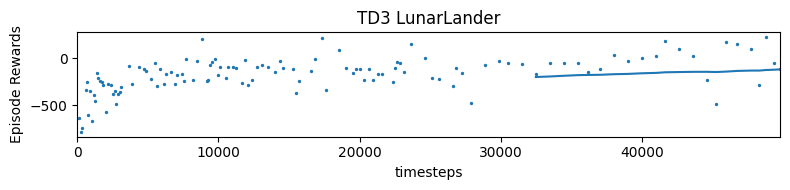

In [9]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander"
)

In [10]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()

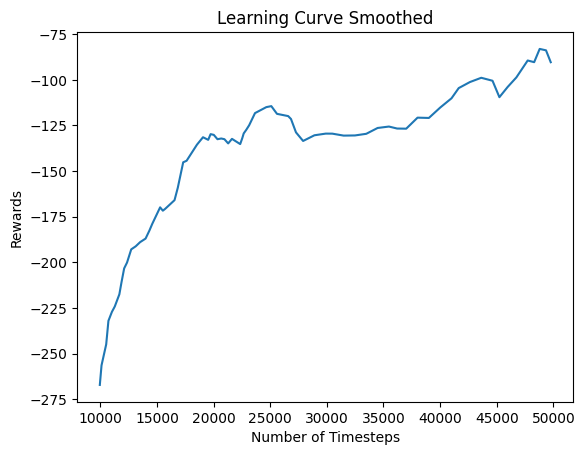

In [11]:
plot_results(log_dir)